# Speech Phoneme Analysis and Classification

#### Francesca Maria Mizzi - 118201L
#### B.Sc in IT (Honours) (Artificial Intelligence)
#### ICS2203 - Natural Language Processing: Methods and Tools

The assigned task consisted of two parts:
 1. Feature Extraction
 2. Classifier

## 1 - Feature Extraction

The product of the first task can be found in the csv file "rawdata.csv" which holds the below data of 150 different speakers pronouncing my chosen 3 words **heed, had, heard**:

 1. SpeakerLabel - the name of the speaker
 2. Gender - the gender of the speaker (F = Female, M = Male)
 3. Word - the word spoken (heed, had or heard)
 4. VowelPhoneme - the vowel phoneme for the word according to ARPABET notation (IY, AE, ER)
 5. ClassNo - the number assigned to each vowel phoneme (1 = IY, 2 = AE, 3 = ER)
 6. Time - the timestamp where the formant values were extracted from (seconds)
 7. Formant1 - the frequency of the first formant in Hz
 8. Formant2 - the frequency of the second formant in Hz
 9. Formant3 - the frequency of the third formant in Hz
 
The 5 different accents I chose to use are:
 1. brm_001
 2. eyk_001
 3. lan_001
 4. roi_001
 5. sse_001

From each of the 5 chosen accents, 10 speakers were selected, 5 female and 5 male, resulting in a total 150 rows.

The 3 formants for each speaker were found using "Praat", a free application which allowed me to choose a specific section of the wav file and find the formants of each vowel, averaging the outputs for a final result.

The csv file will then be used to create the dataset for the second part of the task.

## 2 - Classifier

The second part of the task involved creating a simple k-Nearest Neighbour classifier that tries to determine what
phoneme of speech is being analysed based on formant values.

The first step is to import the necessary libraries in order to build the data classifier.

### Importing libraries

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors
from sklearn import metrics
import numpy as np
import itertools

### Reading dataset

The dataset is then read using the pandas function read_csv(). The columns which are not being used (SpeakerLabel, Gender, Word, ClassNo and Time) are dropped from the dataframe since they are not necessary. The dataset is then printed in order to verify the appropriate columns have been dropped and the whole dataset has been imported.

In [151]:
dataset = pd.read_csv("rawdata.csv")
dataset = dataset.drop(['SpeakerLabel'], axis = 1)
dataset = dataset.drop(['Gender'], axis = 1)
dataset = dataset.drop(['Word'], axis = 1)
dataset = dataset.drop(['ClassNo'], axis = 1)
dataset = dataset.drop(['Time'], axis = 1)
print(dataset)

    VowelPhoneme     Formant1     Formant2     Formant3
0             IY   444.623659  2809.593757  3389.504115
1             AE  1000.117362  1785.756909  2933.149666
2             ER   718.361613  1985.049514  3149.517110
3             IY   593.824486  2738.706465  3328.840620
4             AE   986.417708  1805.294539  3080.968468
..           ...          ...          ...          ...
145           AE   972.530188  1606.190042  2666.531726
146           ER   585.249896  1669.221268  2612.789513
147           IY   319.691652  2357.731836  2820.143564
148           AE   796.434301  1538.121814  3139.960398
149           ER   499.570359  1534.045916  3047.250635

[150 rows x 4 columns]


### Generating the train and test datasets

A function was created in order to split the dataset into train and test. I tried to make my code as modular as possible in order to facilitate code reusability. 

Two variables where created in order to split the data for the prediction later on. data_matrix holds the values of the three formants wihtout the vowel phoneme label while data_labels holds only the vowel phoneme label. Both variables are then split into train and test variables using the sklearn method train_test_split(), specifying a test size of 25%.

In [157]:
def new_dataset():
    data_matrix = dataset.drop(['VowelPhoneme'], axis = 1)
    data_labels = dataset['VowelPhoneme']
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, data_labels, test_size=0.25, shuffle=True)
    return x_train, x_test, y_train, y_test

### Training the model

The function train_model() was used in order to generate the model and predictions from the train and test datasets. 

The model is first fit with the train data, both the values as well as the label. The test data is then put into the model, generating the predictions from the model.

The predictions are then passed into the meterics method confusion_matrix which generates the values for the matrix. The values of the generated matrix are then passed to the function plot_matrix() which does the visual plotting of the confusion matrix. The overall accuracy of the model is then generated using the metrics function accuracy_score() and the result is displayed to the user.

In [159]:
def train_model(model, data_train, label_train, data_test, label_test, class_labels, cm_normalize=True, print_cm=True, cm_map=plt.cm.Greens):
    # to store results at various phases
    results = dict()
    
    # time at which model starts training
    print('Training KNN model..')
    model.fit(data_train, label_train)
    
    # predict test data
    print('Predicting test data...')
    y_pred = model.predict(data_test)
    test_end_time = datetime.now()
    results['predicted'] = y_pred
    
    
    # confusion matrix
    print('Generating confusion matrix...')
    cm = metrics.confusion_matrix(label_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('-----------------------')
        print('CONFUSION MATRIX')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap=cm_map)
    plt.show()
    
    # calculate overall accuracty of the model
    print('Calculating accuracy...')
    accuracy = metrics.accuracy_score(y_true=label_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('-----------------------')
    print('ACCURACY')
    print('\n      {}\n\n'.format(accuracy))
    
    
    # add the trained model to the results
    results['model'] = model
    
    return results

### Plotting the confusion matrix

The plotting of the confusion matrix is done through the below method plot_matrix(). This funcion stores all the values and commands necessary to plot the visual representation of the confusion matrix, mainly through the use of the library matplotlib (plt).

In [160]:
def plot_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap='RdPu')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

### Declaring a new model

The below function new_trial() was used to tie together all the functions created above and make it very simple to create a new model while easily changing the number of k-neighbours. Firstly, new train and test datasets are generated using the function new_dataset(). Then, the parameters for the KNN classifier are defined with the number of neighbours being taken from the parameter of the function. A new kernel is then created using the class neighbors from the library sklearn. A KNN grid is then created from the parameters and kernel defined earlier using the GridSearchCV() function from the sklearn library. That grid is then passed to the train_model() function as well as all the train and test data. As specified earlier, the train_model() function makes use of the plot_matrix() function which plots the confusion matrix.

In [161]:
def new_trial(k):
    data_train, data_test, label_train, label_test = new_dataset()
    knn_params = {'n_neighbors':[k], 'weights': ['uniform','distance'], 'algorithm': ['ball_tree', 'kd_tree','brute']}
    labels = ['IY', 'AE', 'ER']
    knn_kernel = neighbors.KNeighborsClassifier()
    knn_grid = GridSearchCV(knn_kernel, param_grid=knn_params, n_jobs=-1, verbose=1)
    knn_grid_results = train_model(knn_grid, data_train, label_train, data_test, label_test,class_labels=labels)

### Testing the model

The model is then tested with different amount of k-neighbours as well as a different train and test as defined prior using the new_trial() function.

#### k = 3

Training KNN model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Predicting test data...
Generating confusion matrix...
-----------------------
CONFUSION MATRIX

 [[13  1  0]
 [ 3  7  0]
 [ 0  0 14]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


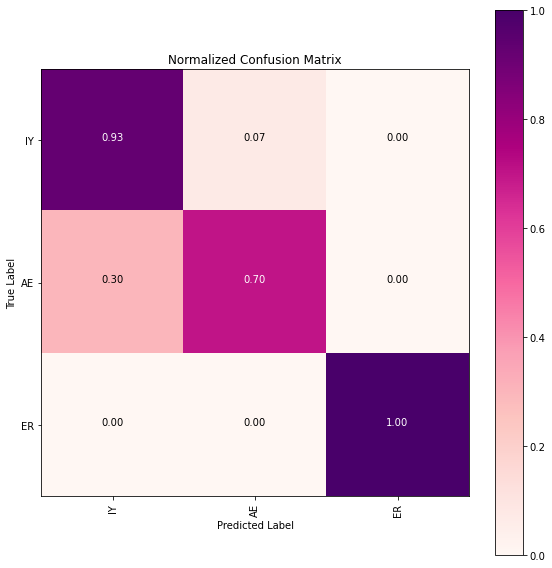

Calculating accuracy...
-----------------------
ACCURACY

      0.8947368421052632




In [164]:
new_trial(3)

#### k = 4

Training KNN model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Predicting test data...
Generating confusion matrix...
-----------------------
CONFUSION MATRIX

 [[14  1  0]
 [ 2  9  0]
 [ 0  1 11]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


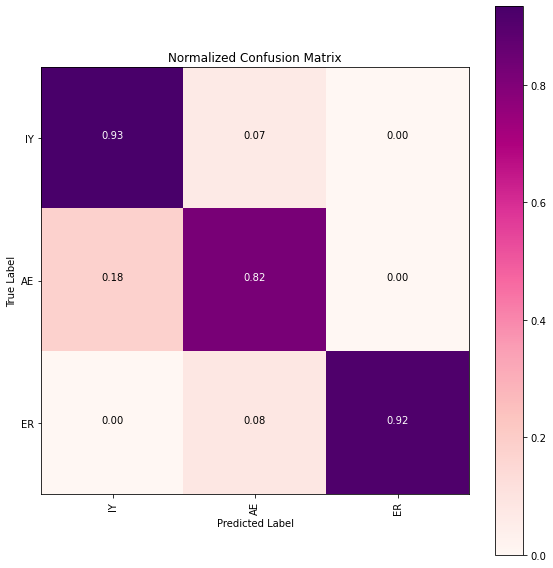

Calculating accuracy...
-----------------------
ACCURACY

      0.8947368421052632




In [165]:
new_trial(4)

#### k = 5

Training KNN model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Predicting test data...
Generating confusion matrix...
-----------------------
CONFUSION MATRIX

 [[ 9  0  0]
 [ 1 13  0]
 [ 0  0 15]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


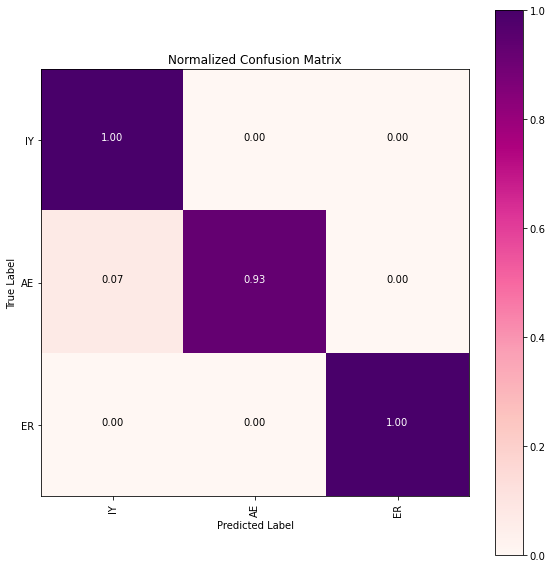

Calculating accuracy...
-----------------------
ACCURACY

      0.9736842105263158




In [170]:
new_trial(5)

#### k = 6

Training KNN model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Predicting test data...
Generating confusion matrix...
-----------------------
CONFUSION MATRIX

 [[12  1  0]
 [ 1 11  0]
 [ 0  1 12]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


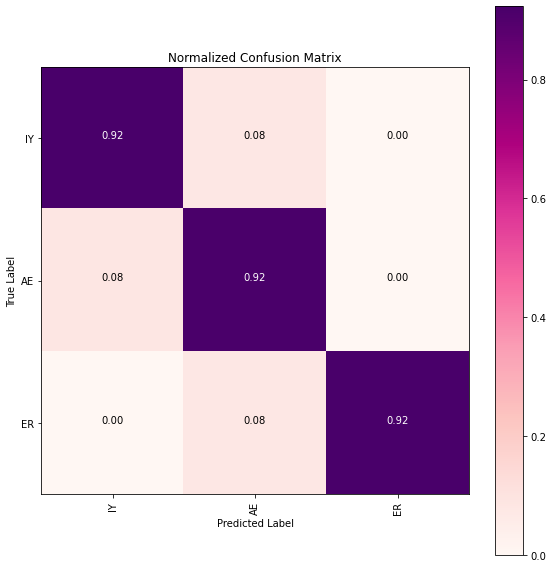

Calculating accuracy...
-----------------------
ACCURACY

      0.9210526315789473




In [167]:
new_trial(6)

#### k = 7

Training KNN model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Predicting test data...
Generating confusion matrix...
-----------------------
CONFUSION MATRIX

 [[15  0  0]
 [ 2 10  0]
 [ 0  0 11]]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


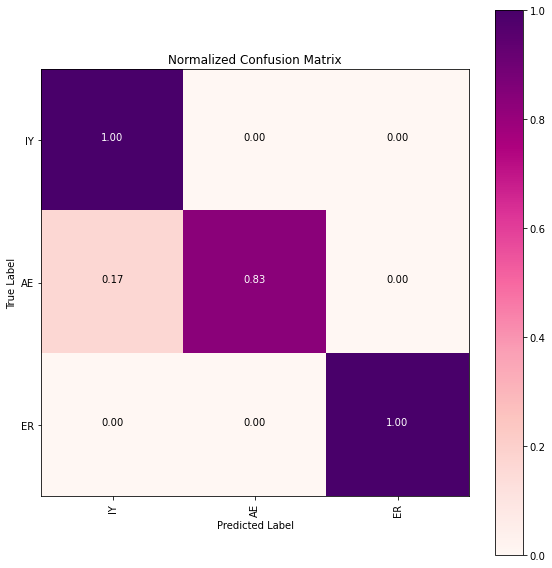

Calculating accuracy...
-----------------------
ACCURACY

      0.9473684210526315




In [171]:
new_trial(7)

### Results

The accuracy results of the 5 tests are as follows:

|K-value|Accuracy|
|------|------|
|3     |89.47%|
|4     |89.47%|
|5     |97.37%|
|6     |92.11%|
|7     |94.74%|

As can be seen from the above the table, the best number of K-neighbours is 5, generating a model with an accuracy of 97.37%.

### Investigation

#### 1 - How does performance change with different values of K? 

#### 2 - What distance metric did you use? Tried any others?

#### 3 - How does performance change when classification is done one data for a single gender alone, or when data from both genders are put together?

#### 4 - What are the vowel-based phonemes that produce the most confusion (base this off your confusion matrix)?